In [1]:
import pandas as pd
from pathlib import Path
from datetime import timedelta
import altair as alt
from IPython.display import Image
from altair_saver import save
from tqdm import tqdm

In [2]:
tqdm.pandas()

In [3]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [4]:
data_path = Path("../Dataset/")

In [5]:
training_data = pd.read_csv(data_path/"Candidate_tech_evaluation_candidate_copy_data science_fraud.csv").drop(columns=['Unnamed: 0'])

In [6]:
training_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0
1,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0
2,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0
3,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0
4,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0


In [7]:
ip_address = pd.read_excel(data_path/"Candidate_tech_evaluation_candidate_copy_datascience_IpAddress_to_Country.xlsx")

In [8]:
ip_address.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216,16777471,Australia
1,16777472,16777727,China
2,16777728,16778239,China
3,16778240,16779263,Australia
4,16779264,16781311,China


In [9]:
ip_address.shape

(138846, 3)

In [10]:
ip_address['lower_bound_ip_address'].min(), ip_address['upper_bound_ip_address'].max()

(16777216, 3758096383)

In [11]:
ip_address['upper_bound_ip_address'].max() > training_data['ip_address'].max()

False

In [12]:
ip_address.loc[ip_address['country']=='United States', 'lower_bound_ip_address'].min()

50331648

In [13]:
ip_address.loc[ip_address['country']=='United States', 'lower_bound_ip_address'].max()

3640651776

In [14]:
ip_address.loc[ip_address['country']=='Canada', 'lower_bound_ip_address'].min()

386924544

In [15]:
training_data['ip_address'].min(), training_data['ip_address'].max()

(93447.13896, 4294850500.0)

In [16]:
op1 = ip_address['lower_bound_ip_address'] >= training_data['ip_address'].min()
op2 = ip_address['upper_bound_ip_address'] <= training_data['ip_address'].max() 
ip_address = ip_address.loc[op1 & op2]

In [17]:
ip_address.shape

(138846, 3)

In [18]:
ip_address['country'].value_counts()

country
United States                            46868
Canada                                    6989
Russian Federation                        6739
Australia                                 6316
Germany                                   5999
                                         ...  
Timor-leste                                  1
Korea Democratic People's Republic of        1
St. Pierre and Miquelon                      1
Tokelau                                      1
Saint Lucia                                  1
Name: count, Length: 235, dtype: int64

In [19]:
training_data['ip_address'].value_counts()

ip_address
3.874758e+09    19
1.502818e+09    17
5.760609e+08    17
2.586669e+09    16
2.171613e+09    16
                ..
1.821870e+09     1
3.560846e+09     1
2.919317e+09     1
3.467285e+09     1
1.174840e+09     1
Name: count, Length: 114134, dtype: int64

In [20]:
def get_ip_country(ip):
    lower_bound = ip_address[ip_address['lower_bound_ip_address']<=ip]
    upper_bound = lower_bound[lower_bound['upper_bound_ip_address']>=ip]
    try:
        country = upper_bound['country'].to_numpy()[0]
    except:
        country = 'Not available'
    return country

In [23]:
training_data['ip_country'] = training_data['ip_address'].progress_apply(get_ip_country)

100%|█████████████████████████████████| 120000/120000 [01:36<00:00, 1244.89it/s]


In [24]:
training_data.shape

(120000, 12)

In [25]:
training_data.to_csv(data_path/"training_data_with_ipCountry.csv")

# Data size

In [26]:
training_data.shape

(120000, 12)

The dataset is imblanced.  
About 9.7% of the record is fraud.  

In [27]:
training_data['class'].value_counts()

class
0    108735
1     11265
Name: count, dtype: int64

In [28]:
training_data['class'].value_counts()[0] / training_data['class'].value_counts()[1]

9.652463382157125

# Data time range

The transactions happend in 2015 and Any user did not signup after Aug 18th.  
Each time feature itself seems to be normal

In [29]:
training_data['signup_time_dt'] = pd.to_datetime(training_data['signup_time'])
training_data['purchase_time_dt'] = pd.to_datetime(training_data['purchase_time'])

In [30]:
training_data['signup_time_dt'].value_counts()

signup_time_dt
2015-01-06 12:10:00    21
2015-01-06 12:53:00    20
2015-01-10 23:23:00    19
2015-01-03 10:47:00    17
2015-01-06 06:33:00    17
                       ..
2015-07-10 10:06:00     1
2015-04-14 11:38:00     1
2015-03-15 09:25:00     1
2015-06-16 04:52:00     1
2015-07-15 15:11:00     1
Name: count, Length: 109111, dtype: int64

In [31]:
training_data['signup_time_dt'].min(), training_data['signup_time_dt'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2015-08-18 04:31:00'))

In [32]:
training_data['purchase_time_dt'].value_counts()

purchase_time_dt
2015-01-06 12:53:00    20
2015-01-06 12:10:00    19
2015-01-10 23:23:00    18
2015-01-03 10:47:00    16
2015-01-06 06:33:00    16
                       ..
2015-04-25 19:25:00     1
2015-05-02 18:24:00     1
2015-06-30 06:09:00     1
2015-11-13 05:48:00     1
2015-09-03 13:45:00     1
Name: count, Length: 100058, dtype: int64

In [33]:
training_data['purchase_time_dt'].min(), training_data['purchase_time_dt'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2015-12-16 02:56:00'))

## **Time Interval**
important feature

When counted each datetime value above, it seemed some records have same datetime for signup and purchase.  
The time difference range between signup and the first purchase is from 0 days to 119 days.  
0 days records are suspicious, especially the records that has no time interval

In [34]:
training_data['days_signup_purchase'] = training_data['purchase_time_dt'] - training_data['signup_time_dt']

In [35]:
training_data['days_signup_purchase'].value_counts().sort_index()

days_signup_purchase
0 days 00:00:00      5936
0 days 00:01:00        85
0 days 00:02:00         1
0 days 00:08:00         1
0 days 00:10:00         1
                     ... 
119 days 23:53:00       2
119 days 23:55:00       1
119 days 23:56:00       1
119 days 23:57:00       1
119 days 23:59:00       2
Name: count, Length: 83730, dtype: int64

In [36]:
training_data['days_signup_purchase'].min(), training_data['days_signup_purchase'].max()

(Timedelta('0 days 00:00:00'), Timedelta('119 days 23:59:00'))

convert timedelta into minutes

In [37]:
training_data['minutes_signup_purchase'] = training_data['days_signup_purchase'].dt.total_seconds() / 60

In [38]:
training_data['minutes_signup_purchase'].value_counts().sort_index()

minutes_signup_purchase
0.0         5936
1.0           85
2.0            1
8.0            1
10.0           1
            ... 
172793.0       2
172795.0       1
172796.0       1
172797.0       1
172799.0       2
Name: count, Length: 83730, dtype: int64

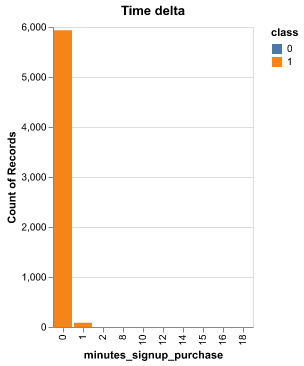

In [40]:
op1 = training_data['minutes_signup_purchase'] <= 20
time_delta_chart = alt.Chart(training_data.loc[op1,['minutes_signup_purchase', 'class']]).mark_bar().encode(
    alt.X('minutes_signup_purchase:N'),
    alt.Y('count()'),
    alt.Color('class:N')
).properties(
    title='Time delta'
)
time_delta_chart.save('./charts/time_delta_plot.png')
Image(filename='./charts/time_delta_plot.png')

In [42]:
op1 = training_data['minutes_signup_purchase'] <= 1
training_data.loc[op1, 'class'].value_counts()

class
1    6021
Name: count, dtype: int64

Among the records with a 0-day interval, the transactions that a purchase was made within 1 minutes are all fraud.  
It is about 53% of all fraud records. this time interval is significant feature for prediction indeed.  

In [43]:
6021 / 11265

0.5344873501997337

Records of fraud transactions are widely spread.

In [44]:
op1 = training_data['class'] == 1
training_data.loc[op1, 'signup_time_dt'].min(), training_data.loc[op1, 'signup_time_dt'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2015-08-18 04:31:00'))

In [45]:
op1 = training_data['class'] == 1
training_data.loc[op1, 'purchase_time_dt'].min(), training_data.loc[op1, 'purchase_time_dt'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2015-12-13 12:00:00'))

(Timestamp('2015-01-01 00:00:00'), Timestamp('2015-12-13 12:00:00'))

## Time
Let's check if the records shows fraud occurred during specific time period.  

In [46]:
training_data['signup_time_h_dt'] = training_data['signup_time_dt'].dt.hour
training_data['purchase_time_h_dt'] = training_data['purchase_time_dt'].dt.hour

There is no specific time period that fraud occurred a lot.  

In [47]:
op1 = training_data['class'] == 1
training_data.loc[op1, ['signup_time_h_dt']].value_counts().sort_index()

signup_time_h_dt
0                   456
1                   410
2                   484
3                   482
4                   406
5                   424
6                   467
7                   424
8                   506
9                   558
10                  502
11                  441
12                  483
13                  482
14                  491
15                  481
16                  476
17                  545
18                  506
19                  536
20                  399
21                  415
22                  422
23                  469
Name: count, dtype: int64

In [48]:
op1 = training_data['class'] == 1
training_data.loc[op1, ['purchase_time_h_dt']].value_counts().sort_index()

purchase_time_h_dt
0                     441
1                     450
2                     467
3                     492
4                     398
5                     439
6                     482
7                     432
8                     523
9                     531
10                    487
11                    447
12                    493
13                    464
14                    477
15                    495
16                    486
17                    549
18                    482
19                    484
20                    409
21                    454
22                    413
23                    470
Name: count, dtype: int64

# Purchase values

Histogram and box plot shows that it is not common for the purchase value to exceeds 80 dollars.

<Axes: >

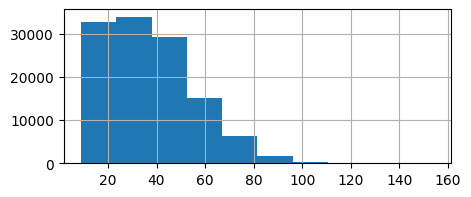

In [50]:
training_data['purchase_value'].hist(figsize=(5,2))

To see if such records are related to fraud, I divided records by quantiles.  

In [51]:
training_data[['purchase_value']].describe()

,purchase_value
count,120000.000000
mean,36.881475
std,18.325855
min,9.000000
25%,22.000000
50%,34.000000
75%,49.000000
max,154.000000


<Axes: >

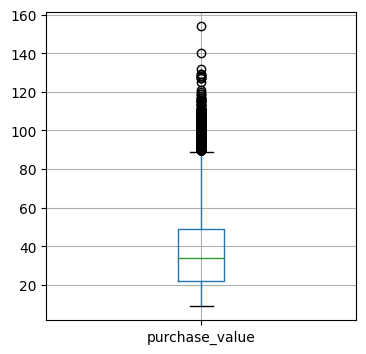

In [52]:
training_data[['purchase_value']].boxplot(figsize=(4,4))

In [53]:
def get_purchase_range(purchase):
    if purchase <= 22:
        return 'purchase_Q1'
    elif purchase in range(23, 34):
        return 'purchase_Q2'
    elif purchase in range(34, 49):
        return 'purchase_Q3'
    else:
        return 'purchase_upper_Q'
    

In [54]:
training_data['purchase_range'] = training_data['purchase_value'].apply(get_purchase_range)

As we can see in pivot table, each quantile area shows about 9 to 10% of fraud records proportion which is not 

In [55]:
purchase_pivot = pd.pivot_table(training_data, index='purchase_range', values=['user_id'], columns=['class'], aggfunc='count')
purchase_pivot.columns = ['0','1']
# print(purchase_pivot.sum(axis=1))
purchase_pivot['proportion'] = round(purchase_pivot['1'] / purchase_pivot.sum(axis=1), 2)
purchase_pivot

,0,1,proportion
purchase_range,,,
purchase_Q1,27465,2893,0.10
purchase_Q2,24729,2480,0.09
purchase_Q3,29170,2925,0.09
purchase_upper_Q,27371,2967,0.10


# **DEVICE**
import feature

Some device is used for multiple users.  
In most cases, one device was used less than 3 times.  
Therefore, if same device appear more than 3 times, it is suspicious.

<Axes: >

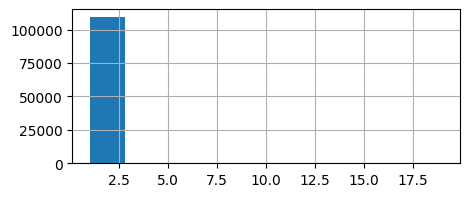

In [56]:
training_data['device_id'].value_counts().hist(figsize=(5,2))

Counted how many times the device appears in dataset and map the appearance number as 'device_count' column.

In [57]:
device_map = training_data['device_id'].value_counts().to_dict()

In [58]:
training_data['device_count'] = training_data['device_id'].map(device_map)

In [59]:
op1 = training_data['device_count'] >= 4
training_data.loc[op1, 'class'].value_counts()

class
1    6033
0     605
Name: count, dtype: int64

The transaction records that are made by devices used more than 3 times are highly fraud records.  
The proportion of fraud records in each devices is more than 80%.

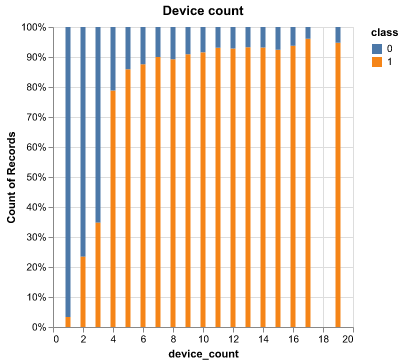

In [60]:
device_count_chart = alt.Chart(training_data[['device_count','source', 'class']]).mark_bar().encode(
    alt.X('device_count'),
    alt.Y('count()').sort('-x').stack("normalize"),
    alt.Color('class:N')
).properties(
    title='Device count'
)
device_count_chart.save('./charts/device_count_plot.png')
Image(filename='./charts/device_count_plot.png')

# Source

There is no significant difference between source groups.

In [61]:
source_pivot = pd.pivot_table(training_data, index='source', values=['user_id'], columns=['class'], aggfunc='count').loc[['SEO', 'Ads', 'Direct']]
source_pivot.columns = ['0','1']
# print(purchase_pivot.sum(axis=1))
source_pivot['proportion'] = round(source_pivot['1'] / source_pivot.sum(axis=1), 2)
source_pivot

,0,1,proportion
source,,,
SEO,43945,4352,0.09
Ads,43109,4352,0.09
Direct,21681,2561,0.11


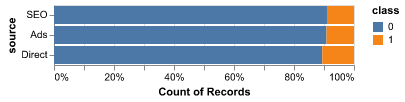

In [62]:
source_chart = alt.Chart(training_data[['purchase_value','source', 'class']]).mark_bar().encode(
    alt.X('count()').stack('normalize'),
    alt.Y('source:N').sort('-x'),
    alt.Color('class:N')
)
source_chart.save('./charts/source_chart.png')
Image(filename='./charts/source_chart.png')

I checked if there are some difference by time for each source group.  
But I could not find meaningful difference by time.  
So I made time range as below.  
- 6 to 11 : morning
- 12 to 17 : afternoon
- 18 to 23 : evening
- 24 to 5 : night

In [63]:
def set_time_group(time):
    if time in range(6, 12):
        return 'morning'
    elif time in range(12, 18):
        return 'afternoon'
    elif time in range(18, 24):
        return 'evening'
    else:
        return 'night'

In [64]:
training_data['sign_time_range'] = training_data['signup_time_h_dt'].apply(set_time_group)
training_data['purchase_time_range'] = training_data['purchase_time_h_dt'].apply(set_time_group)

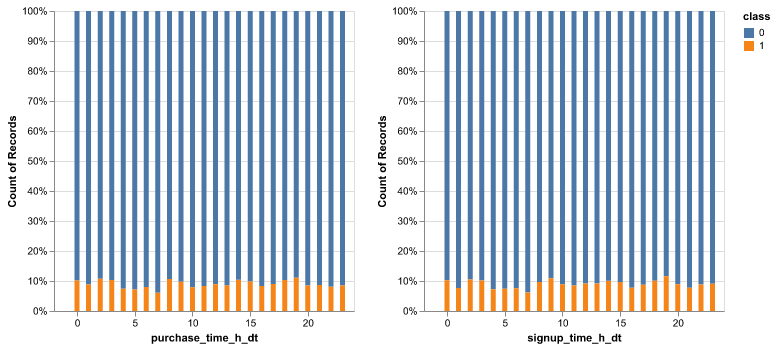

In [65]:
purchase_chart = alt.Chart(training_data[['source', 'purchase_time_h_dt', 'class']]).mark_bar().encode(
                alt.X('purchase_time_h_dt'),
                alt.Y('count()').stack('normalize'),
                alt.Color('class:N')
            ).transform_filter(
                alt.FieldEqualPredicate(field='source', equal='SEO')
            )

signup_chart = alt.Chart(training_data[['source', 'signup_time_h_dt', 'class']]).mark_bar().encode(
                alt.X('signup_time_h_dt'),
                alt.Y('count()').stack('normalize'),
                alt.Color('class:N')
            ).transform_filter(
                alt.FieldEqualPredicate(field='source', equal='SEO')
            )

seo_time_chart = purchase_chart | signup_chart
seo_time_chart.save('./charts/seo_time_chart.png')
Image(filename='./charts/seo_time_chart.png')

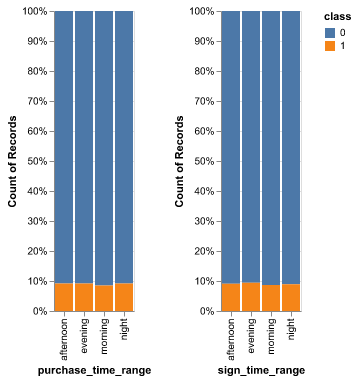

In [66]:
purchase_chart = alt.Chart(training_data[['source', 'purchase_time_range', 'class']]).mark_bar().encode(
                alt.X('purchase_time_range'),
                alt.Y('count()').stack('normalize'),
                alt.Color('class:N')
            ).transform_filter(
                alt.FieldEqualPredicate(field='source', equal='SEO')
            )

signup_chart = alt.Chart(training_data[['source', 'sign_time_range', 'class']]).mark_bar().encode(
                alt.X('sign_time_range'),
                alt.Y('count()').stack('normalize'),
                alt.Color('class:N')
            ).transform_filter(
                alt.FieldEqualPredicate(field='source', equal='SEO')
            )

seo_time_range_chart = purchase_chart | signup_chart
seo_time_range_chart.save('./charts/seo_time_range_chart.png')
Image('./charts/seo_time_range_chart.png')

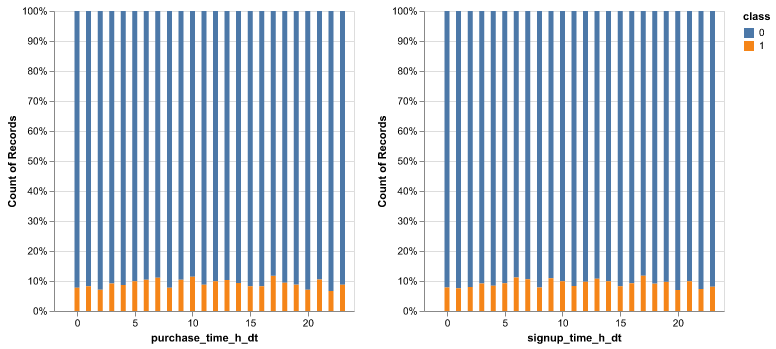

In [67]:
purchase_chart = alt.Chart(training_data[['source', 'purchase_time_h_dt', 'class']]).mark_bar().encode(
                alt.X('purchase_time_h_dt'),
                alt.Y('count()').stack('normalize'),
                alt.Color('class:N')
            ).transform_filter(
                alt.FieldEqualPredicate(field='source', equal='Ads')
            )

signup_chart = alt.Chart(training_data[['source', 'signup_time_h_dt', 'class']]).mark_bar().encode(
                alt.X('signup_time_h_dt'),
                alt.Y('count()').stack('normalize'),
                alt.Color('class:N')
            ).transform_filter(
                alt.FieldEqualPredicate(field='source', equal='Ads')
            )

ads_time_chart = purchase_chart | signup_chart
ads_time_chart.save('./charts/ads_time_chart.png')
Image('./charts/ads_time_chart.png')

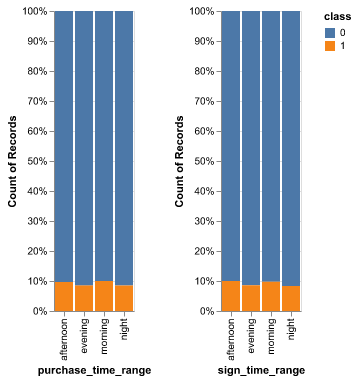

In [68]:
purchase_chart = alt.Chart(training_data[['source', 'purchase_time_range', 'class']]).mark_bar().encode(
                alt.X('purchase_time_range'),
                alt.Y('count()').stack('normalize'),
                alt.Color('class:N')
            ).transform_filter(
                alt.FieldEqualPredicate(field='source', equal='Ads')
            )

signup_chart = alt.Chart(training_data[['source', 'sign_time_range', 'class']]).mark_bar().encode(
                alt.X('sign_time_range'),
                alt.Y('count()').stack('normalize'),
                alt.Color('class:N')
            ).transform_filter(
                alt.FieldEqualPredicate(field='source', equal='Ads')
            )

ads_time_range_chart = purchase_chart | signup_chart
ads_time_range_chart.save('./charts/ads_time_range_chart.png')
Image('./charts/ads_time_range_chart.png')

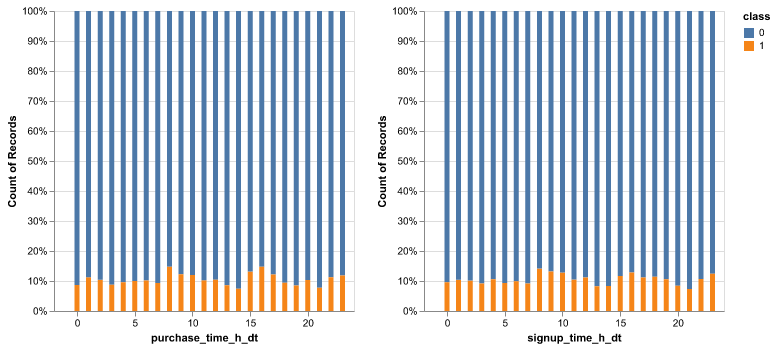

In [69]:
purchase_chart = alt.Chart(training_data[['source', 'purchase_time_h_dt', 'class']]).mark_bar().encode(
                alt.X('purchase_time_h_dt'),
                alt.Y('count()').stack('normalize'),
                alt.Color('class:N')
            ).transform_filter(
                alt.FieldEqualPredicate(field='source', equal='Direct')
            )

signup_chart = alt.Chart(training_data[['source', 'signup_time_h_dt', 'class']]).mark_bar().encode(
                alt.X('signup_time_h_dt'),
                alt.Y('count()').stack('normalize'),
                alt.Color('class:N')
            ).transform_filter(
                alt.FieldEqualPredicate(field='source', equal='Direct')
            )

direct_time_chart = purchase_chart | signup_chart
direct_time_chart.save('./charts/direct_time_chart.png')
Image('./charts/direct_time_chart.png')

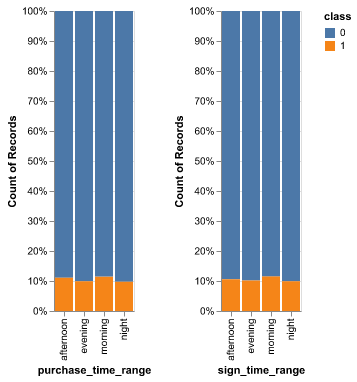

In [70]:
purchase_chart = alt.Chart(training_data[['source', 'purchase_time_range', 'class']]).mark_bar().encode(
                alt.X('purchase_time_range'),
                alt.Y('count()').stack('normalize'),
                alt.Color('class:N')
            ).transform_filter(
                alt.FieldEqualPredicate(field='source', equal='Direct')
            )

signup_chart = alt.Chart(training_data[['source', 'sign_time_range', 'class']]).mark_bar().encode(
                alt.X('sign_time_range'),
                alt.Y('count()').stack('normalize'),
                alt.Color('class:N')
            ).transform_filter(
                alt.FieldEqualPredicate(field='source', equal='Direct')
            )

direct_time_range_chart = purchase_chart | signup_chart
direct_time_range_chart.save('./charts/direct_time_range_chart.png')
Image('./charts/direct_time_range_chart.png')

# Browser

In [71]:
browser_pivot = pd.pivot_table(training_data, index='browser', values=['user_id'], columns=['class'], aggfunc='count').loc[['Chrome','IE', 'Safari','FireFox','Opera']]
browser_pivot.columns = ['0','1']
# print(purchase_pivot.sum(axis=1))
browser_pivot['proportion'] = round(browser_pivot['1'] / browser_pivot.sum(axis=1), 2)
browser_pivot

,0,1,proportion
browser,,,
Chrome,43814,4838,0.10
IE,26629,2509,0.09
Safari,17820,1800,0.09
FireFox,17769,1846,0.09
Opera,2703,272,0.09


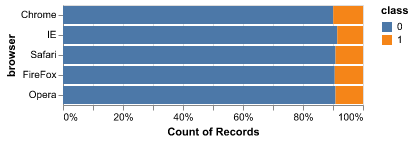

In [72]:
browser_chart = alt.Chart(training_data[['purchase_value', 'browser', 'class']]).mark_bar().encode(
    alt.X('count()').stack('normalize'),
    alt.Y('browser:N').sort('-x'),
    alt.Color('class:N')
)
browser_chart.save('./charts/browser_chart.png')
Image('./charts/browser_chart.png')

# SEX

In [73]:
sex_pivot = pd.pivot_table(training_data, index='sex', values=['user_id'], columns=['class'], aggfunc='count').loc[['M','F']]
sex_pivot.columns = ['0','1']
# print(purchase_pivot.sum(axis=1))
sex_pivot['proportion'] = round(sex_pivot['1'] / sex_pivot.sum(axis=1), 2)
sex_pivot

,0,1,proportion
sex,,,
M,63433,6693,0.10
F,45302,4572,0.09


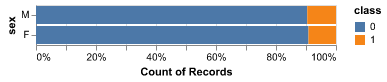

In [74]:
sex_chart = alt.Chart(training_data[['purchase_value','sex', 'class']]).mark_bar().encode(
    alt.X('count()').stack('normalize'),
    alt.Y('sex:N').sort('-x'),
    alt.Color('class:N')
)
sex_chart.save('./charts/sex_chart.png')
Image('./charts/sex_chart.png')

# AGE

When look into proportion of fraud transaction by age group, some age group shows higher rate than others.  
However, It is not meaningful to separate transaction by each age.  
For example, 63 year old transaction shows high proportion, but 62 or 64 has low proportion.  
It is hard to think that 63 year old and 62 year old is that different.  
And transaction record of 63 year old is not that many.  
It would be better to set some age range.

In [75]:
age_pivot = pd.pivot_table(training_data, index='age', values=['user_id'], columns=['class'], aggfunc='count')
age_pivot.columns = ['0','1']
# print(purchase_pivot.sum(axis=1))
age_pivot['proportion'] = round(age_pivot['1'] / age_pivot.sum(axis=1), 2)
age_pivot.sort_values(by='proportion')

,0,1,proportion
age,,,
62,48.0,2.0,0.04
59,116.0,5.0,0.04
64,23.0,1.0,0.04
49,1018.0,61.0,0.06
60,78.0,5.0,0.06
46,1551.0,123.0,0.07
43,2460.0,226.0,0.08
21,2752.0,237.0,0.08
25,3816.0,327.0,0.08


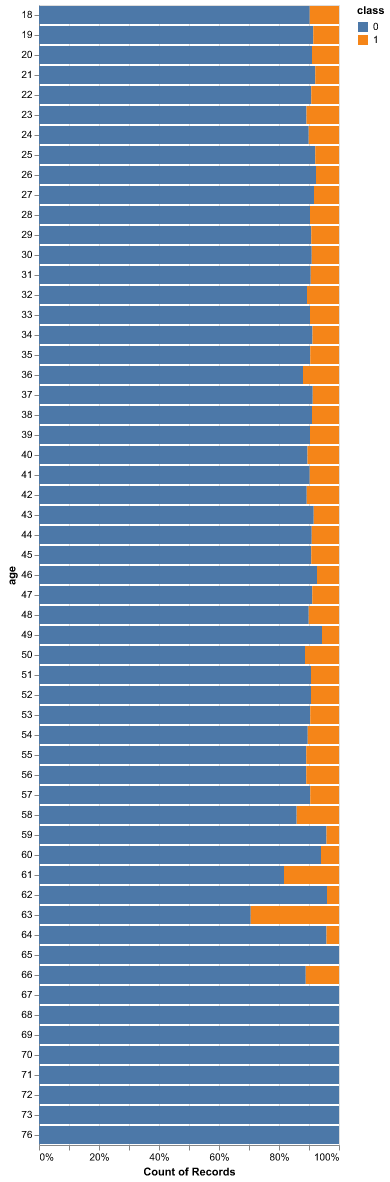

In [76]:
age_chart = alt.Chart(training_data[['purchase_value','age', 'class']]).mark_bar().encode(
    alt.X('count()').stack('normalize'),
    alt.Y('age:N', axis=alt.Axis(grid=True)),
    alt.Color('class:N')
)
age_chart.save('./charts/age_chart.png')
Image('./charts/age_chart.png')

I divided the transactions into several age groups: 10 years interval.  
It appears that in age group, there is no significant difference.  

In [77]:
def get_age_group(age):
    if age in range(18, 28):
        return 'age 1'
    elif age in range(28, 38):
        return 'age 2'
    elif age in range(38, 48):
        return 'age 3'
    elif age in range(48, 58):
        return 'age 4'
    elif age in range(58, 67):
        return 'age 5'
    else:
        return 'age 6'

In [78]:
training_data['age_group'] = training_data['age'].apply(get_age_group)

In [79]:
age_group_pivot = pd.pivot_table(training_data, index='age_group', values=['user_id'], columns=['class'], aggfunc='count')
age_group_pivot.columns = ['0','1']
# print(purchase_pivot.sum(axis=1))
age_group_pivot['proportion'] = round(age_group_pivot['1'] / age_group_pivot.sum(axis=1), 2)
age_group_pivot

,0,1,proportion
age_group,,,
age 1,31206.0,3042.0,0.09
age 2,45282.0,4861.0,0.10
age 3,25773.0,2679.0,0.09
age 4,5919.0,616.0,0.09
age 5,535.0,67.0,0.11
age 6,20.0,NaN,NaN


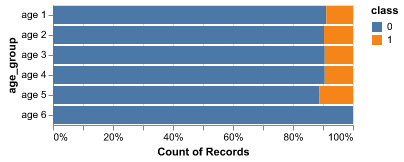

In [80]:
age_group_chart = alt.Chart(training_data[['purchase_value','age_group', 'class']]).mark_bar().encode(
    alt.X('count()').stack('normalize'),
    alt.Y('age_group:N', axis=alt.Axis(grid=True)),
    alt.Color('class:N')
)
age_group_chart.save('./charts/age_group_chart.png')
Image('./charts/age_group_chart.png')

In [81]:
def get_age_group2(age):
    if age in range(18, 23):
        return 'age 01'
    elif age in range(23, 28):
        return 'age 02'
    elif age in range(28, 33):
        return 'age 03'
    elif age in range(33, 38):
        return 'age 04'
    elif age in range(38, 43):
        return 'age 05'
    elif age in range(43, 49):
        return 'age 06'
    elif age in range(49, 54):
        return 'age 07'
    elif age in range(54, 59):
        return 'age 08'
    elif age in range(59, 64):
        return 'age 09'
    elif age in range(64, 69):
        return 'age 10'
    else:
        return 'age 11'

In [82]:
training_data['age_group2'] = training_data['age'].apply(get_age_group2)

In [83]:
age_group_pivot2 = pd.pivot_table(training_data, index='age_group2', values=['user_id'], columns=['class'], aggfunc='count')
age_group_pivot2.columns = ['0','1']
# print(purchase_pivot.sum(axis=1))
age_group_pivot2['proportion'] = round(age_group_pivot2['1'] / age_group_pivot2.sum(axis=1), 2)
age_group_pivot2.sort_index()

,0,1,proportion
age_group2,,,
age 01,12227.0,1191.0,0.09
age 02,18979.0,1851.0,0.09
age 03,23196.0,2469.0,0.10
age 04,22086.0,2392.0,0.10
age 05,16328.0,1786.0,0.10
age 06,10697.0,1034.0,0.09
age 07,3564.0,345.0,0.09
age 08,1254.0,155.0,0.11
age 09,336.0,40.0,0.11


# **Country**
importand feature  
proportion of fraud records shows difference by country group.

In [84]:
17418 / 120000

0.14515

Most of the transaction occurred at United States.  
And about 14.5% of the tranasaction is not determined the country by ip bound.

In [85]:
training_data['ip_country'].value_counts()

ip_country
United States     46184
Not available     17418
China              9532
Japan              5735
United Kingdom     3580
                  ...  
Madagascar            1
Myanmar               1
Cape Verde            1
Vanuatu               1
Gibraltar             1
Name: count, Length: 177, dtype: int64

In [86]:
country_proportion = training_data[training_data['class']==1].groupby('ip_country').size() / training_data.groupby('ip_country').size()
country_proportion = country_proportion.fillna(0).reset_index(name='proportion_country')

In [87]:
country_proportion.sort_values(by='proportion_country', ascending=False)

,ip_country,proportion_country
162,Turkmenistan,1.000000
173,Virgin Islands (U.S.),0.500000
113,Namibia,0.400000
96,Luxembourg,0.392857
151,Sri Lanka,0.363636
...,...,...
64,Gibraltar,0.000000
63,Ghana,0.000000
60,Gambia,0.000000
59,Gabon,0.000000


In [88]:
sorted_data = pd.merge(training_data, country_proportion, on='ip_country', how='left')

In [89]:
sorted_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,minutes_signup_purchase,signup_time_h_dt,purchase_time_h_dt,purchase_range,device_count,sign_time_range,purchase_time_range,age_group,age_group2,proportion_country
0,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,...,82661.0,4,14,purchase_Q2,2,night,afternoon,age 4,age 07,0.096830
1,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,...,113304.0,12,4,purchase_Q2,1,afternoon,night,age 1,age 01,0.103911
2,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,...,36689.0,0,12,purchase_Q1,1,night,afternoon,age 1,age 02,0.096830
3,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,...,2693.0,13,10,purchase_Q2,1,afternoon,morning,age 2,age 04,0.091589
4,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,...,85995.0,21,14,purchase_Q2,1,evening,afternoon,age 2,age 04,0.092648


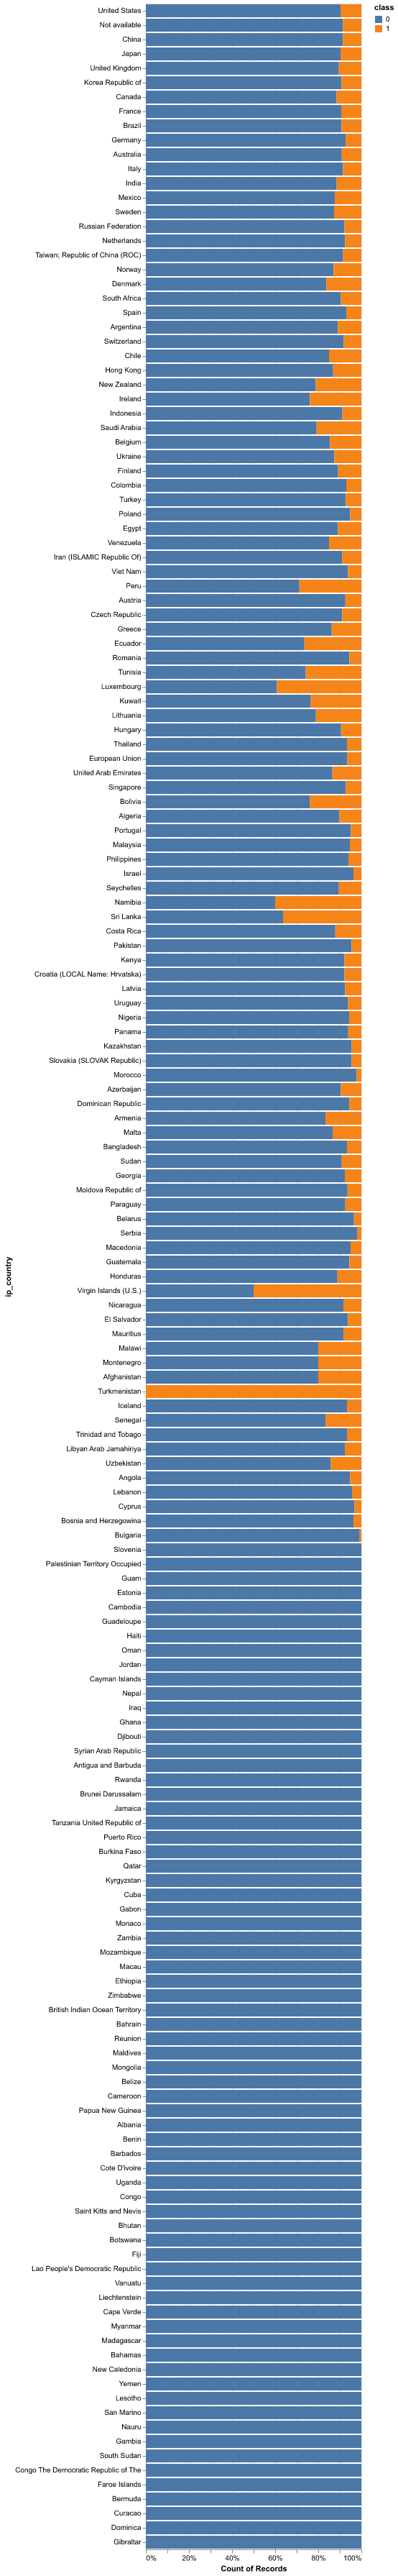

In [90]:
age_chart = alt.Chart(sorted_data[['ip_country', 'class', 'proportion_country']]).mark_bar().encode(
    alt.X('count()').stack('normalize'),
    alt.Y('ip_country:N', axis=alt.Axis(grid=True), sort=alt.EncodingSortField(field='proportion_country', order='descending')),
    alt.Color('class:N')
)
age_chart.save('./charts/ip_country.png')
Image('./charts/ip_country.png')

### Country & purchasement value

Fraud Purchase value distribution for each country:  
If we plot mean of purchase value of fraud and non-fraud, there might be difference between countries.  
Interestingly, some country shows mean of fraud purchase amount is lower than mean of non fraud purchasement amount.  
In either way, there is some difference.  

In [91]:
training_data.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'ip_country', 'signup_time_dt', 'purchase_time_dt',
       'days_signup_purchase', 'minutes_signup_purchase', 'signup_time_h_dt',
       'purchase_time_h_dt', 'purchase_range', 'device_count',
       'sign_time_range', 'purchase_time_range', 'age_group', 'age_group2'],
      dtype='object')

In [92]:
pd.pivot_table(training_data, index=['ip_country'], values=['purchase_value'], columns=['class'], aggfunc='mean').sort_values(by=('purchase_value',1), ascending=False)

purchase_value            
class                                   0           1
ip_country                                           
Bosnia and Herzegowina          40.692308  104.000000
Namibia                         37.916667   69.000000
Slovakia (SLOVAK Republic)      35.140625   62.333333
Mauritius                       30.545455   57.000000
Hungary                         37.207792   55.625000
...                                   ...         ...
Uganda                          35.200000         NaN
Vanuatu                         24.000000         NaN
Yemen                           26.000000         NaN
Zambia                          30.625000         NaN
Zimbabwe                        43.200000         NaN

[177 rows x 2 columns]

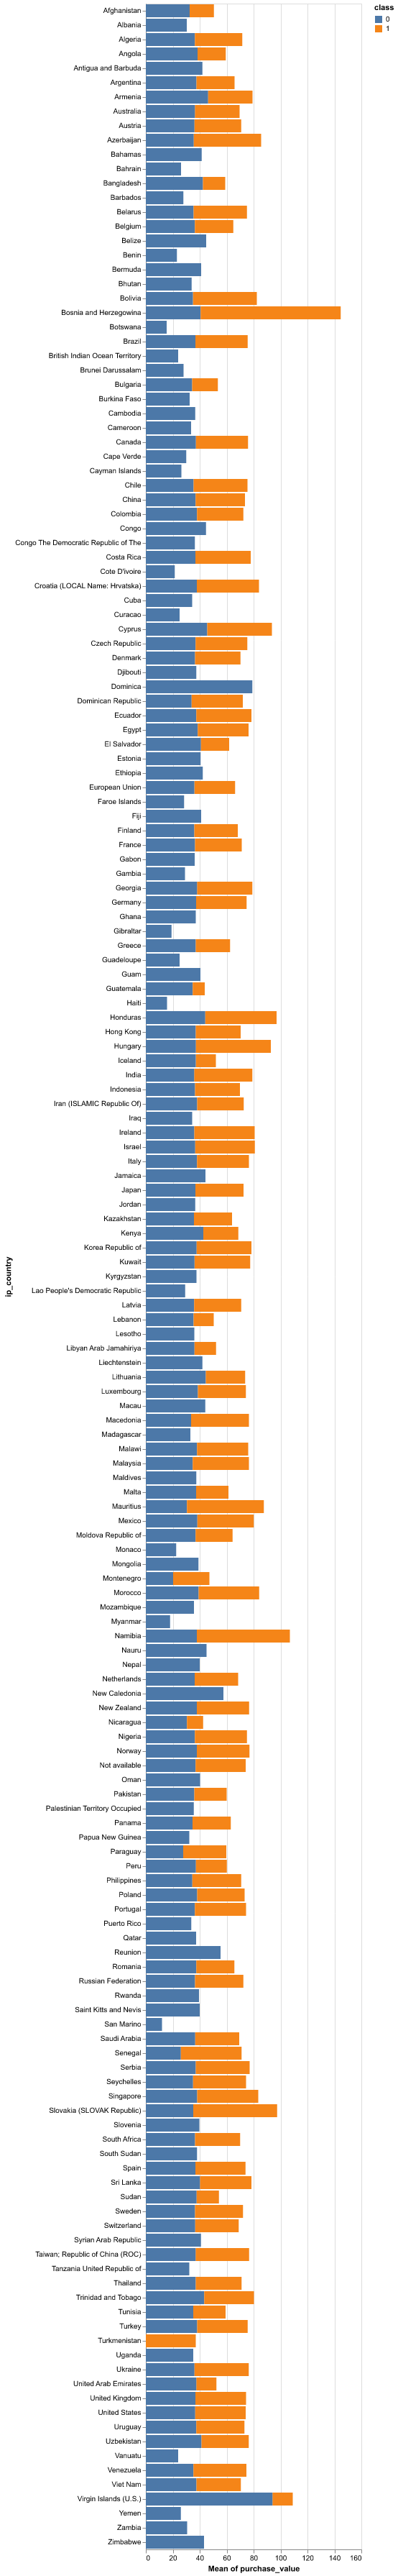

In [93]:
age_chart = alt.Chart(sorted_data[['ip_country', 'class', 'purchase_value']]).mark_bar().encode(
    alt.X('mean(purchase_value):Q'),
    alt.Y('ip_country:N'),
    alt.Color('class:N')
)
age_chart.save('./charts/country_fraud_purchase_amount.png')
Image('./charts/country_fraud_purchase_amount.png')

### Country & Source:
Source data can be useful when it combines with country data.  
For example, New Zealand shows the proportion of fraud records as 21%.  
But if source of the transaction is Direct, proportion decrease to 5%.  

In [94]:
country_source_pivot = pd.pivot_table(training_data, index=['ip_country','source'], values=['user_id'], columns=['class'], aggfunc='count')
country_source_pivot = country_source_pivot.fillna(0)
country_source_pivot.columns = ['0','1']
# print(purchase_pivot.sum(axis=1))
country_source_pivot['proportion'] = round(country_source_pivot['1'] / country_source_pivot.sum(axis=1), 2)
country_source_pivot

0    1  proportion
ip_country  source                      
Afghanistan Ads     1.0  0.0         0.0
            Direct  0.0  1.0         1.0
            SEO     3.0  0.0         0.0
Albania     Ads     4.0  0.0         0.0
            Direct  2.0  0.0         0.0
...                 ...  ...         ...
Zambia      Direct  1.0  0.0         0.0
            SEO     3.0  0.0         0.0
Zimbabwe    Ads     1.0  0.0         0.0
            Direct  3.0  0.0         0.0
            SEO     1.0  0.0         0.0

[473 rows x 3 columns]

### Country & time range
When look into some country that has high proportion of fraud transaction records,  
the proportion of fraud transaction is different by time.  

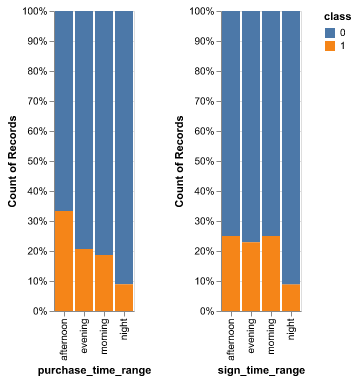

In [95]:
purchase_chart = alt.Chart(training_data[['ip_country', 'purchase_time_range', 'class']]).mark_bar().encode(
                alt.X('purchase_time_range'),
                alt.Y('count()').stack('normalize'),
                alt.Color('class:N')
            ).transform_filter(
                alt.FieldEqualPredicate(field='ip_country', equal='New Zealand')
            )

signup_chart = alt.Chart(training_data[['ip_country', 'sign_time_range', 'class']]).mark_bar().encode(
                alt.X('sign_time_range'),
                alt.Y('count()').stack('normalize'),
                alt.Color('class:N')
            ).transform_filter(
                alt.FieldEqualPredicate(field='ip_country', equal='New Zealand')
            )

direct_time_range_chart = purchase_chart | signup_chart
direct_time_range_chart.save('./charts/Newzealand_time_range_chart.png')
Image('./charts/Newzealand_time_range_chart.png')

But in case the country has low fraud traction proportion, it seems time is nothing to do with fraud transaction.  

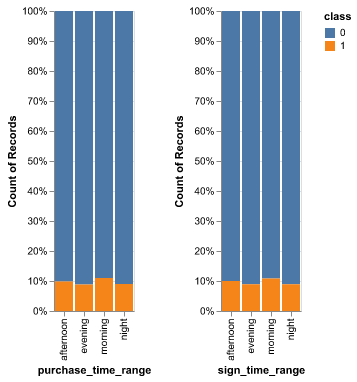

In [96]:
purchase_chart = alt.Chart(training_data[['ip_country', 'purchase_time_range', 'class']]).mark_bar().encode(
                alt.X('purchase_time_range'),
                alt.Y('count()').stack('normalize'),
                alt.Color('class:N')
            ).transform_filter(
                alt.FieldEqualPredicate(field='ip_country', equal='United States')
            )

signup_chart = alt.Chart(training_data[['ip_country', 'sign_time_range', 'class']]).mark_bar().encode(
                alt.X('sign_time_range'),
                alt.Y('count()').stack('normalize'),
                alt.Color('class:N')
            ).transform_filter(
                alt.FieldEqualPredicate(field='ip_country', equal='United States')
            )

direct_time_range_chart = purchase_chart | signup_chart
direct_time_range_chart.save('./charts/UnitedStates_time_range_chart.png')
Image('./charts/UnitedStates_time_range_chart.png')

# Compare value of False positive and False negative
False negative: If model predict fraud as normal  
False positive: If model predict normal as fraud

In [97]:
op1 = training_data['class'] == 1
training_data.loc[op1, ['purchase_value']].mean()

purchase_value    37.066134
dtype: float64

If False negative occurr Electronica will lose approximatelly \\$37 per record.  
On the other hand, If False positive occurr Electronica will lose \\$8 per record.  
Therefore model should prevent False negative more than False positive.  
=> Recall score should be high.  

# Conclusion

Through the EDA, I concluded that below features would be helpful to predict fraud records.
- Time interval between signup and the first purchasement in minutes.
- Device_id frequancy: the number that the device id appeared in dataset.
- Country: determined by numeric ip address boundary.  
-- in case country column exists --  
- Purchasement value
- Time range: morning, afternoon, evening, night.
- Source 

Important metric to evaluate the model: Recall score